In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
# %pip install --upgrade pip
# %pip install --force-reinstall "ray[tune]" hyperopt


In [3]:
import sys
sys.path.insert(0, '../')  


In [4]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
#from cvaei.models.cvae_inference import CVAE
from cvaei.examples.gk_dist import GKDistribution
from cvaei.models.multitask_cvae import MultiTaskCVAE


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [5]:
gk_dist = GKDistribution()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = gk_dist.prepare_data(100000)
observed_data = gk_dist.observed_data()
#gk_dist.check_normalizer()

Training Theta Shape: torch.Size([100000, 4])
Training Data Shape: torch.Size([100000, 1000])
Validation Theta Shape: torch.Size([10000, 4])
Validation Data Shape: torch.Size([10000, 1000])


In [6]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([100000, 4]), torch.Size([100000, 1000]))

# Initialise the Model

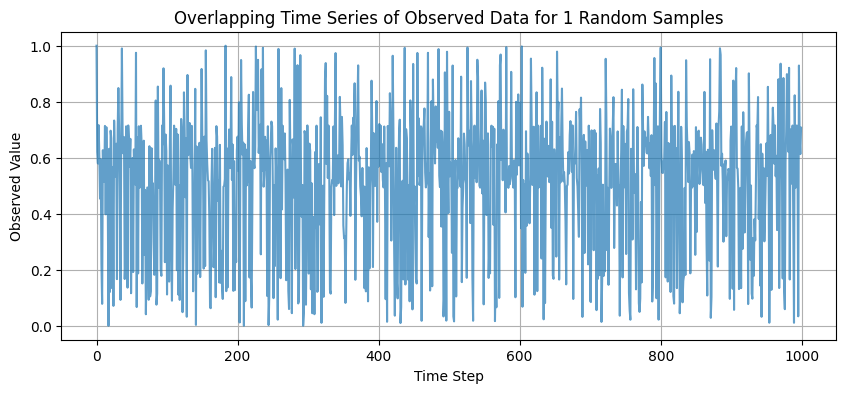

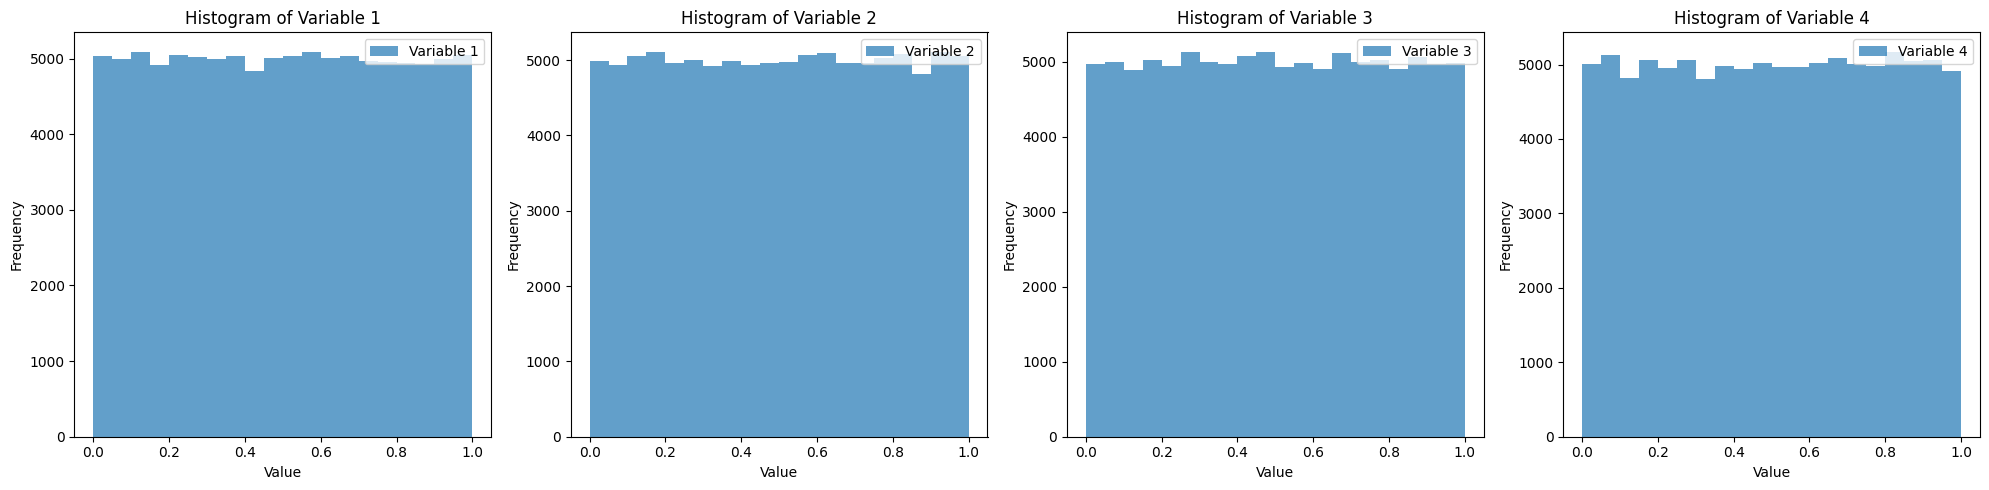

In [7]:
gk_dist.plot_observation(train_data_norm, num_samples =1)
gk_dist.plot_prior(train_theta_norm)

# Define the CVAE Network

In [8]:
input_dim = 4
latent_dim = 20
conditional_dim = 1000
encoder_hidden_dims = [1024]
decoder_hidden_dims = [1024,1024]
activation_fn = nn.LeakyReLU(0.1)

# network = CVAE(input_dim=input_dim, 
#                latent_dim=latent_dim, 
#                output_dim=input_dim,
#                 conditional_dim=conditional_dim,
#                 encoder_hidden_dims=encoder_hidden_dims,
#                 decoder_hidden_dims=decoder_hidden_dims,
#                 activation_fn = activation_fn,
#                 w_recon=1.0, 
#                 w_misfit=0.01,
# )

network = MultiTaskCVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=1.0)

optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

# network.tune_model(train_loader = train_loader, 
#                 validation_loader = validation_loader,
#                 theta_normalizer=theta_normalizer,
#                 data_normalizer=data_normalizer,
#                 forward_model= gk_dist.simulator)

In [9]:
print(network)

MultiTaskCVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=1024, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=1024, out_features=20, bias=True)
  )
  (decoder): MultiTaskDecoder(
    (layers): Sequential(
      (0): Linear(in_features=1020, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (output_layer_1): Linear(in_features=1024, out_features=4, bias=True)
    (output_layer_2): Linear(in_features=1024, out_features=1000, bias=True)
  )
)


In [10]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20,
                    num_cycles = 1,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    
                    patience=100)

Using CPU for training.
Epoch 1/20: Beta: 0.0, total_loss: 12.4127, recon_loss: 0.0431, misfit_loss: 12.3696, kl_div: 0.0000
Epoch 1/20 Validation: total_loss: 5.4577, recon_loss: 0.0109, misfit_loss: 5.4468, kl_div: 0.0000

Epoch 1: Validation loss improved to 0.00054577
Epoch 2/20: Beta: 0.1, total_loss: 3.8345, recon_loss: 0.0371, misfit_loss: 3.7360, kl_div: 0.0614
Epoch 2/20 Validation: total_loss: 19.1971, recon_loss: 0.1132, misfit_loss: 19.0646, kl_div: 0.0192

Epoch 2: No improvement in validation loss for 1 epochs.
Epoch 3/20: Beta: 0.2, total_loss: 2.1911, recon_loss: 0.0264, misfit_loss: 2.1637, kl_div: 0.0010
Epoch 3/20 Validation: total_loss: 2.0973, recon_loss: 0.0212, misfit_loss: 2.0760, kl_div: 0.0001

Epoch 3: Validation loss improved to 0.00020973
Epoch 4/20: Beta: 0.3, total_loss: 1.3344, recon_loss: 0.0222, misfit_loss: 1.3120, kl_div: 0.0003
Epoch 4/20 Validation: total_loss: 3.4642, recon_loss: 0.0304, misfit_loss: 3.4336, kl_div: 0.0002

Epoch 4: No improvement

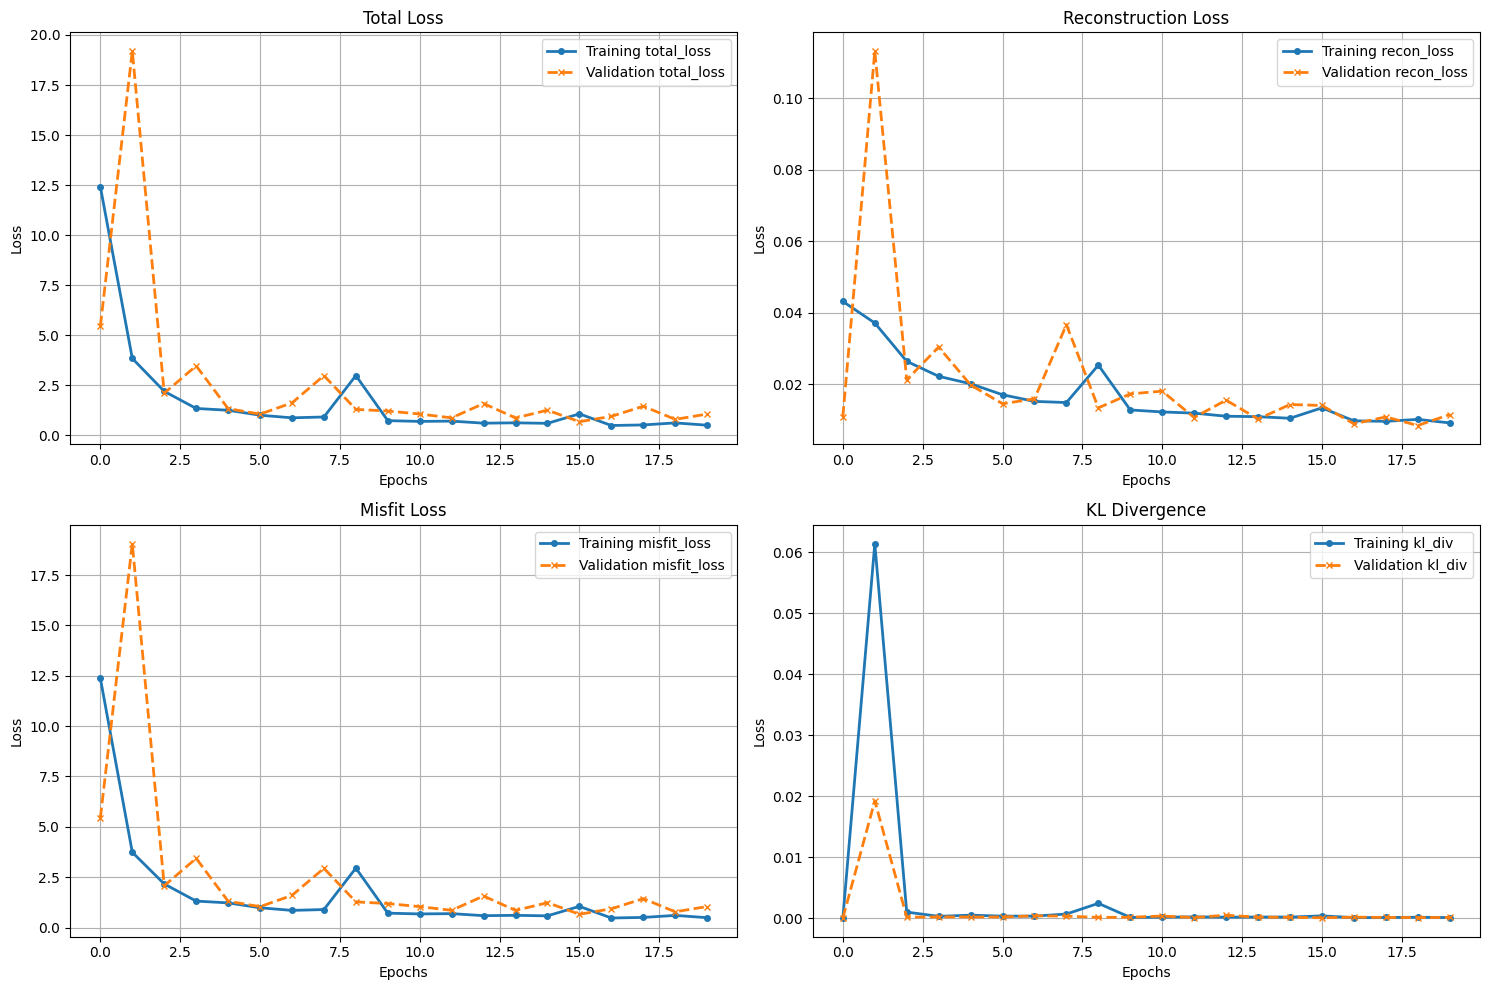

In [11]:
network.plot_loss()

# Inference

In [12]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


In [13]:
#gk_dist.plot_posterior(post)

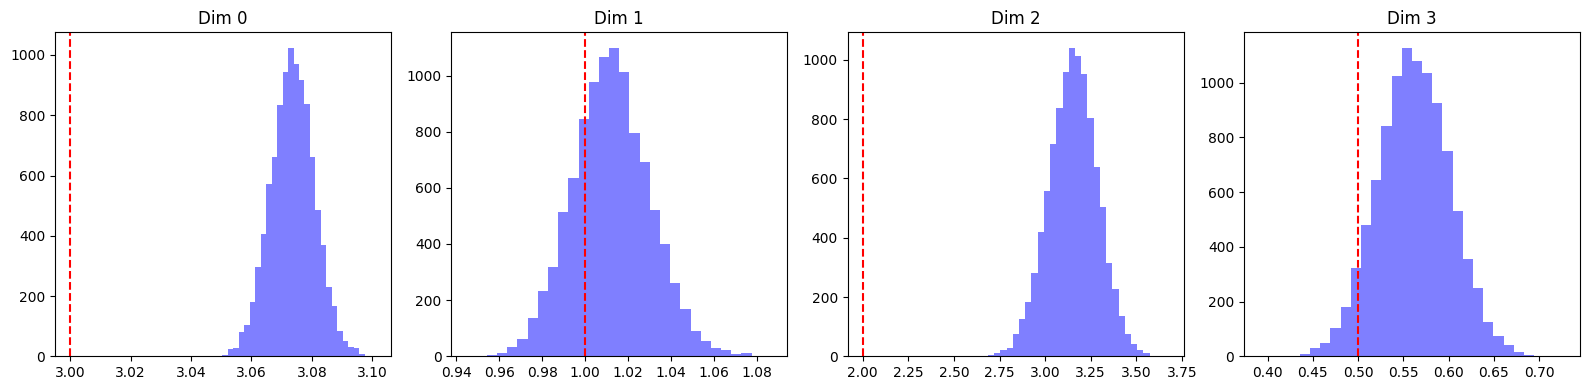

In [14]:
gk_dist.posterior_hist(post)